# Hierarchical_Bayes

In this section of our project we are trying to create an intensity map to display at what locations a particular animal in the US is likely to be found.  Specifically, we are focusing on deer, though this could easily be applied to other animals as well.  

It is important to note that by looking at counts from different years (in the time series notebook), we found that there are more data points as years go on.  We have theorized that this may be due to scientists using the gbif website to record more as they may have found this site to be more useful.  There could also be an increase in the number of deer studies.  This raises the question as to whether this is reliable data. Sightings may also depend on where the scientists decided to look for these animals, as it is unlikely there are people sweeping the entirety of the US to look for deer.  Much of the data probably depends on scientific study patterns and may not reflect actual deer population.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import itertools

## Downloading Data

This is all US deer data uploaded to gbif up through the year 2015.  

In [2]:
# Load Data

full = pd.read_csv('deer.csv',sep='\t')
full.head()

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,...,recordnumber,identifiedby,rights,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,1088894118,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/849723,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Alces,Alces americanus,...,NaN,NaN,© Charlie Hohn some rights reserved,Charlie Hohn,Charlie Hohn,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
1,1088900045,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1247846,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© dwest some rights reserved,dwest,dwest,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
2,1088904736,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1257570,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Odocoileus,Odocoileus virginianus,...,NaN,NaN,© byzantinenature some rights reserved,byzantinenature,byzantinenature,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
3,1088905648,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1259468,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© pdatema some rights reserved,pdatema,pdatema,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
4,1088920945,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1299029,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© BJ Stacey some rights reserved,BJ Stacey,BJ Stacey,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;TAXON_MATCH_HIGHERRANK;GEOD...


In [3]:
full.columns.values

array(['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'countrycode', 'locality', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'rights',
       'rightsholder', 'recordedby', 'typestatus', 'establishmentmeans',
       'lastinterpreted', 'mediatype', 'issue'], dtype=object)

In [4]:
full[['locality','decimallatitude','decimallongitude','eventdate','day','month','year']].head(30)

,locality,decimallatitude,decimallongitude,eventdate,day,month,year
0,NaN,43.16769,-72.64119,2014-08-26T19:59Z,26,8,2014
1,NaN,38.12045,-121.93823,2015-02-19T17:50Z,19,2,2015
2,NaN,40.09893,-85.61851,2015-02-25T00:00Z,25,2,2015
3,NaN,45.18113,-84.34583,2015-02-25T19:10Z,25,2,2015
4,NaN,41.22412,-124.09071,2015-02-14T00:00Z,14,2,2015
5,NaN,44.24394,-72.78249,2015-03-23T00:00Z,23,3,2015
6,NaN,38.16600,-122.93700,2015-03-31T20:00Z,31,3,2015
7,"Anchorage, Anchorage International Airport",NaN,NaN,1961-02-18T00:00Z,18,2,1961
8,specific locality not recorded,NaN,NaN,1961-08-22T00:00Z,22,8,1961
9,4 mi S of Anaktuvuk Pass,NaN,NaN,1962-10-08T00:00Z,8,10,1962


In [19]:
data = full[['decimallatitude','decimallongitude','year']]
data = data.dropna()
data.head()

,decimallatitude,decimallongitude,year
0,43.16769,-72.64119,2014
1,38.12045,-121.93823,2015
2,40.09893,-85.61851,2015
3,45.18113,-84.34583,2015
4,41.22412,-124.09071,2015


__Notes:__  

Data may be affected by number of year we include.  If we use multiple years, the areas with more dear could increase total sightings for the area more quickly than areas with less dear.  So we could be artificially widening the gap in deer counts between more highly populated areas and less populated areas.  For now I would like to look at just 2015 to be safe. This year also has the most data points to study.

In [20]:
data[data['year']==2015].values.shape

(1280, 3)

In [21]:
data2015 = data[data['year']==2015]
data2015 = data2015[['decimallatitude','decimallongitude']]
data2015.head()

,decimallatitude,decimallongitude
1,38.12045,-121.93823
2,40.09893,-85.61851
3,45.18113,-84.34583
4,41.22412,-124.09071
5,44.24394,-72.78249


## Data Exploration

In [22]:
data2015.shape

(1280, 2)

#### Grids

We create grids to bin our deer counts.  This will allow us to keep track of how many deer there are in a given space, of a size which we set.  To keep this consistent with our other studies, the number of grid squares and corresponding real-life latitude/longitude coordinates were kept the same.

In [23]:
# Create the 10.0 x 10.0 lat-long grid squares
# Changing the size of the lat-long grid squares will have a large effect on the results
lats = np.arange(-90, 100, 5)
longs = np.arange(-180, 190, 5)

# Generate the grid
grids = list(itertools.product(lats, longs))

num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids

Using these lat-long settings, there are 2812 grid squares


In [39]:
# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

In [40]:
# returns grid_id index
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))

In [41]:
print 'lat ids: ', np.array(grid_ids)[:,0]
print 'long ids: ', np.array(grid_ids)[:,1]

lat ids:  [ 1  1  1 ..., 38 38 38]
long ids:  [ 1  2  3 ..., 72 73 74]


In [42]:
def make_grid_counts(data):
    # create store for grid id indexes
    grid_counts = np.zeros(len(grid_ids))

    # Build grid counts
    for i in range(0, len(data)):
        # get grid id index
        idx = get_grid_id_from_lat_long(data.iloc[i,0],data.iloc[i,1])

        # add to grid_counts
        grid_counts[idx] += 1
    
    return grid_counts

In [46]:
def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()

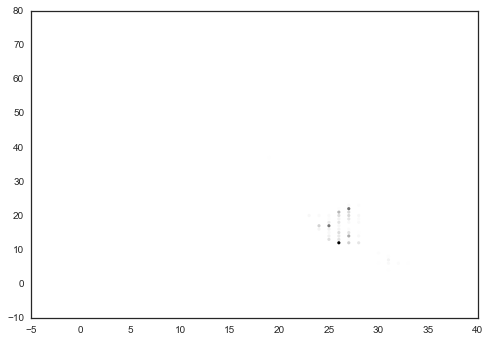

In [53]:
grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

In [54]:
sum(grid_counts)

1280.0

The deer counts appear to be located in a particular region, and from this view do not seem to be in high number.  We will add more years to add to this dataset.

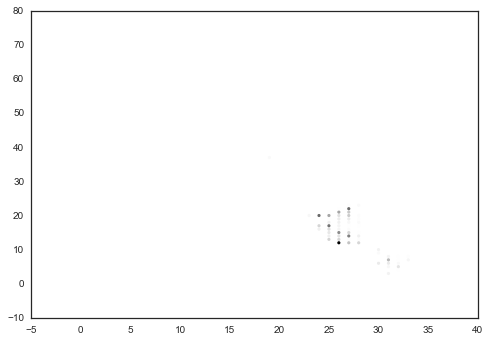

In [56]:
# look at more years
data_trial = data[data['year'] > 1992]
grid_counts = make_grid_counts(data_trial)
plot_grid(grid_counts)

In [57]:
sum(grid_counts)

5818.0

This seems to have created more counts, but mostly in the same region.

#### Playing with Grid Sizing

Instead, the problem seems to be with our grid sizing.  We will "zoom in" to this region of sightings.  Looking at the ranges of original latitudes and longitudes we see that indeed the grid size was too large for the region in which the deer appear.

In [107]:
print min(data2015.decimallatitude.values), max(data2015.decimallatitude.values)
print min(data2015.decimallongitude.values), max(data2015.decimallongitude.values)

0.0 70.71133
-164.08596 0.0


In [108]:
print min(data_2011_2015.decimallatitude.values), max(data_2011_2015.decimallatitude.values)
print min(data_2011_2015.decimallongitude.values), max(data_2011_2015.decimallongitude.values)

0.0 70.71133
-165.3881 0.0


Using the 2015 data again, we will play with different grid shapes, adjusting the sizes and ranges to look in, based on the plot we saw previously.  The smaller search space seems to work better.

In [109]:
# try again with different grids
lats = np.arange(0, 100, 2)
longs = np.arange(-180, 0, 2)

# Generate the grid
grids = list(itertools.product(lats, longs))

num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids



# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

# returns grid_id index
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))


def make_grid_counts(data):
    # create store for grid id indexes
    grid_counts = np.zeros(len(grid_ids))

    # Build grid counts
    for i in range(0, len(data)):
        # get grid id index
        idx = get_grid_id_from_lat_long(data.iloc[i,0],data.iloc[i,1])

        # add to grid_counts
        grid_counts[idx] += 1
    
    return grid_counts

def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=20, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()

Using these lat-long settings, there are 4500 grid squares


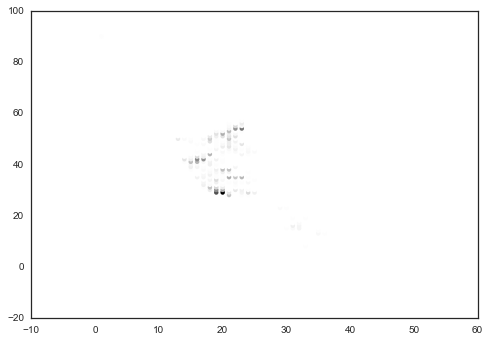

In [110]:
grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

The results look good, though we can still take a closer look.

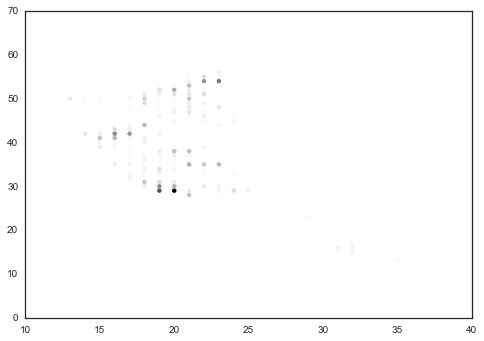

In [154]:
# settings zoomed in for 2015 data
def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=20, c=colors, cmap='gray_r', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.show()

grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

Focus on this area:  


x: [10, 40]  
y: [0, 70]  


Looking at this region we can see that the distribution in number of deer can be related to number of deer in close proximity.  In other words, having a large number of deer in one area signifies a large number of deer in its surrounding regions.  We can therefore use a Poisson distribution to model it and create an intensity surface.

## Start Modeling

Preliminary run using HW4 as starting code

In [112]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        
        if i%100 == 0:
            print i
        f = mcmc_samples[i-1,:]
        #print f, Y
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

In [165]:
X = np.array(grid_ids)
M = grid_counts.size
w = 1


In [166]:
#Calculate Sigma
phi = 0.00001
sigma = np.zeros((M+1, M+1))
sigma[0,0] = 1
small_offset = 0.00001

for x in range (M):
    for y in range (M):
        if x == y:
            sigma[x+1,y+1] = np.exp( -( (X[x:x+1,0] - X[y:y+1,0])**2 + (X[x:x+1,1] - X[y:y+1,1])**2   )/phi  )+small_offset
        else:
            sigma[x+1,y+1] = np.exp( -( (X[x:x+1,0] - X[y:y+1,0])**2 + (X[x:x+1,1] - X[y:y+1,1])**2   )/phi  )
        

In [167]:
# log likelihood for poisson
#lambda_x = f[0] + f[x+1]
#do the poisson pmf = (w^2 * lambda_x)

def log_likelihood_func (f, Y):
    result = 0
    for x in range(M):
        result = result + scipy.stats.poisson.logpmf(Y[x],w**2 * np.exp(f[0] + f[x+1]))
    return result

In [168]:
N_mcmc = 1000
burn_in = 500

results = ess(grid_counts, sigma,log_likelihood_func, N_mcmc, burn_in, M+1)

running elliptical slice sampling...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [171]:
# plot comparison
# Create a new plotting function to show side by side comparisons
def plot_compare(counts, counts2):

    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(121)
    colors = counts / np.double(np.max(counts))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.title("Original Data Intensity Map")
    
    plt.subplot(122)    
    colors2 = counts2 / np.double(np.max(counts2))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors2, marker = 'o', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.title("Posterior Mean Intensity Map")
    plt.show()

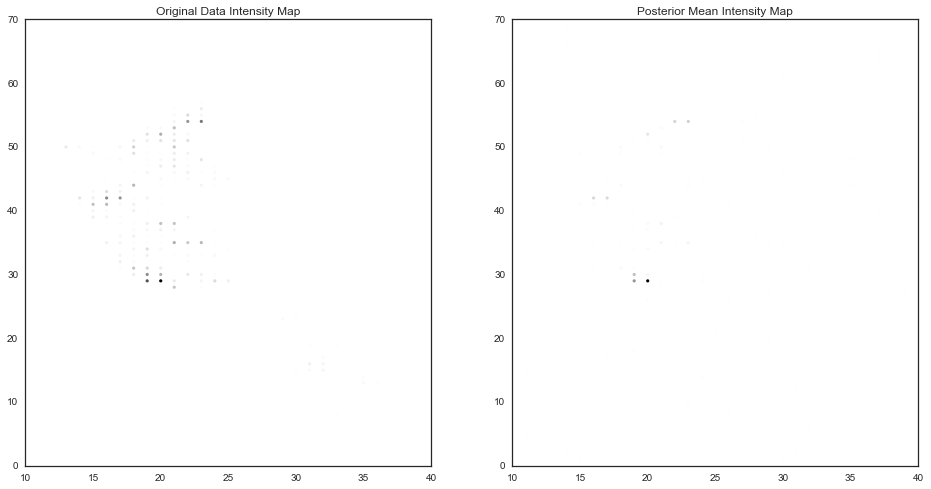

In [172]:
final_results = results.mean(axis=0)

non_conjugate_lambdas = []
for x in range(M):
    non_conjugate_lambdas.append(np.exp(final_results[0] + final_results[x+1])) 

plot_compare(grid_counts, np.array(non_conjugate_lambdas))

The MAP value is: -2.02376470754


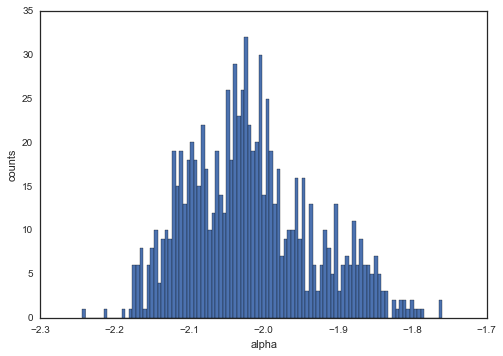

In [173]:
# did it converge
p_hist = plt.hist(results[100:,0], bins=100)
xx= np.linspace(-3,7,101)
plt.xlabel("alpha")
plt.ylabel("counts")
p_map_index = np.argmax(p_hist[0])
p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
p_map = p_hist_bin_middle[p_map_index]
print "The MAP value is:",p_map

__TO DO__  
- play around with phi
- try more animal types, to get more spread out data points
- try a pymc implementation